# Linear Autoregression
<hr style="border:2px solid black">

**Autoregressive Model**
- time series model that uses observations from previous time steps as input to a regression equation
- predicts the value at the next time step
- very simple idea that can result in accurate forecasts on a range of time series problems

<hr style="border:2px solid black">

## 1. Getting Started

### 1.1 Load Packages

In [21]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.linear_model import LinearRegression

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

### 1.3 Load Data

In [23]:
df = pd.read_csv("../data/milk_remainder.csv").set_index('date')
df.head()

,remainder
date,
1962-01-01,8.028350
1962-02-01,16.345584
1962-03-01,1.970510
1962-04-01,0.595436
1962-05-01,8.528055


### 1.4 Plot Data

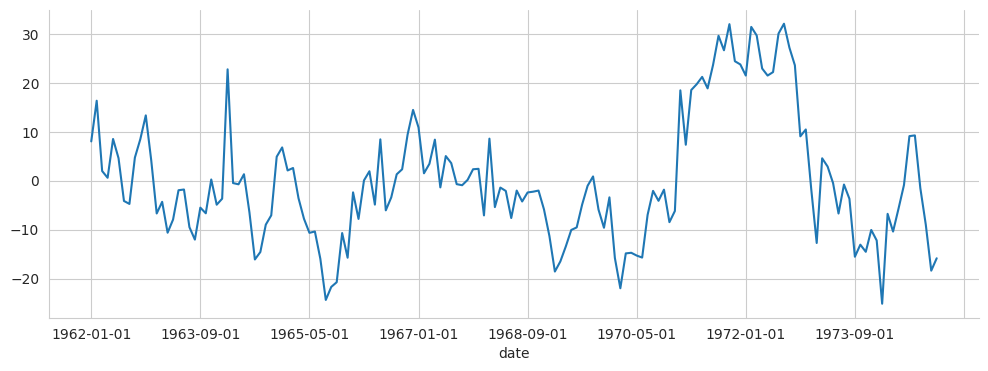

In [24]:
df['remainder'].plot(figsize=(12,4))
sns.despine()

<hr style="border:2px solid black">

## 2. Time-Lagged Feature

***A lag is an interval of time between two related observations***

In [4]:
# maximum interval to consider
p = 3
lags = [i+1 for i in range(p)]

for lag in lags:
    column_name = 'lag' + str(lag)
    df[column_name] = df['remainder'].shift(lag)

In [5]:
df.head()

,remainder,lag1,lag2,lag3
date,,,,
1962-01-01,8.028350,NaN,NaN,NaN
1962-02-01,16.345584,8.028350,NaN,NaN
1962-03-01,1.970510,16.345584,8.028350,NaN
1962-04-01,0.595436,1.970510,16.345584,8.028350
1962-05-01,8.528055,0.595436,1.970510,16.345584


In [6]:
df.tail()

,remainder,lag1,lag2,lag3
date,,,,
1974-08-01,9.254258,9.109953,-0.880505,-5.717117
1974-09-01,-1.524515,9.254258,9.109953,-0.880505
1974-10-01,-8.995595,-1.524515,9.254258,9.109953
1974-11-01,-18.389752,-8.995595,-1.524515,9.254258
1974-12-01,-15.860832,-18.389752,-8.995595,-1.524515


### 2.1 Autocorrelation Scatterplot

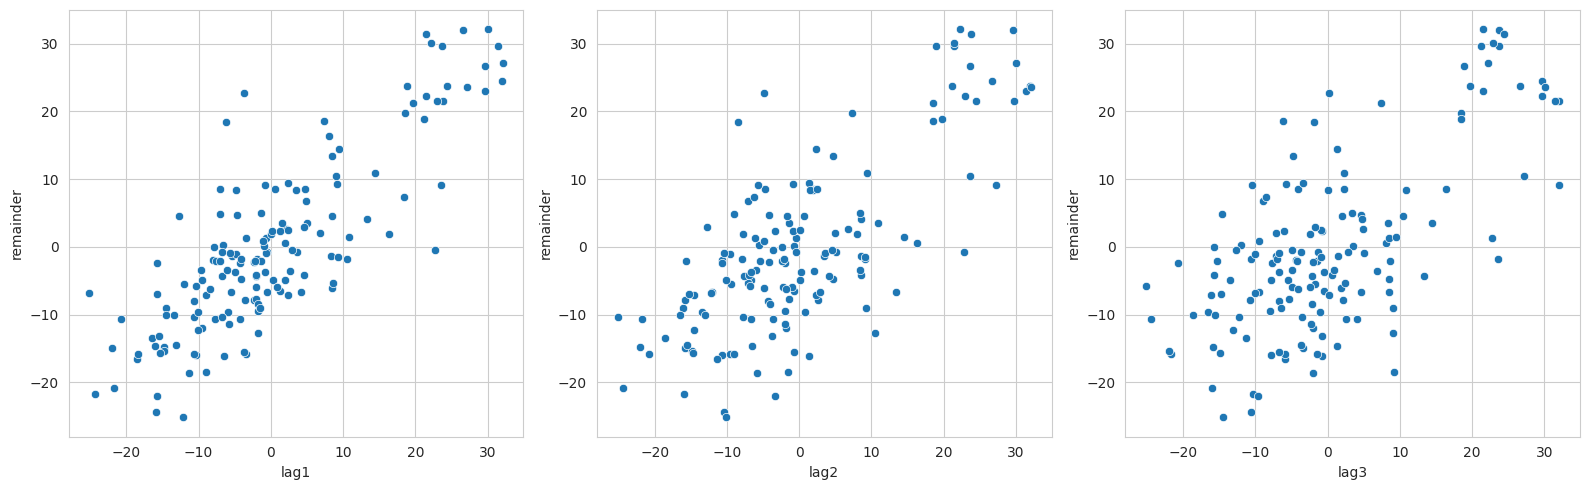

In [7]:
import matplotlib.gridspec as gridspec
#sns.set() # set seaborn as default style

lag_columns = df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(df[lag_columns[i]],df['remainder'],ax=axes[i])
    
plt.tight_layout()

### 2.2 Autocorrelation Heatmap

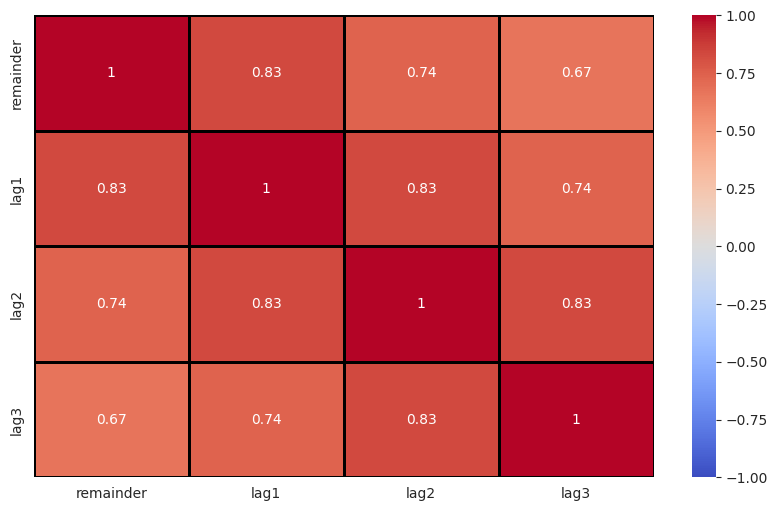

In [8]:
plt.rcParams['figure.figsize'] = (10,6)
sns.heatmap(round(df.corr(),2), 
            cmap = "coolwarm",
            linecolor='black', 
            linewidth=1, 
            annot=True,
            vmin=-1, 
            vmax=1
           );

**Observation**
- There is fairly strong correlation between data and time-lagged features
- A positive remainder this month would hints towards a positive remainder next month. If this month more passengers than expected were flying, then the number of passengers flying next month is likely to be higher than predicted by trend and seasonality.

<hr style="border:2px solid black">

## 3. Autoregressive (AR) Model

In an autoregressive model, one models the present value of a variable by looking at the past values of the same variable:

>$$
y_{t} = c + \sum_{j=1}^{p}\phi_{j}y_{t-j} + \epsilon_t,
$$ 

where we have an AR($p$) model, with
>- $t$ the current timestep
>- $c$ the *bias/intercept* 
>- $\phi_j$’s the *weights* of the model
>- $\epsilon$ the *error*; some *independent and identically distributed (iid) noise*, e.g., Gaussian noise
>- $p$ the number of lags to use, called the *order* of the model, is a hyperparameter to be chosen

For the noise, it holds that
>- $E(\epsilon_t)=E(\epsilon)=0$: $~~~~~~~~~~~~~~~~$time-invariant expectation value of zero
>- $V(\epsilon_t)=V(\epsilon)=\text{constant}$: $~~~~$time-invariant variance

### Examples

**AR(1) Model**: $~~~~~\hat{y_{t}} = c + \phi_1 * y_{t-1}$
- The value at timestep $t$ as a linear function of the value at $t-1$

**AR(2) Model**: $~~~~~\hat{y_{t}} = c + \phi_1 * y_{t-1} + \phi_2 * y_{t-2}$
- The value at timestep $t$ as a linear function of the values at $t-1$ and $t-2$

### Backshift Operator *B*
>$By_t=y_{t-1},\qquad B²y_t=By_{t-1}=y_{t-2},\quad\cdots\quad B^py_t=y_{t-p}$

**AR(*p*) Model**
> $$
y_{t} = c + \sum_{j=1}^{p}\phi_{j}B^{\,j}y_t + \epsilon_t,\qquad or \quad
\left(1-\sum_{j=1}^{p}\phi_{j}B^{\,j}\right)y_t = c + \epsilon_t,
$$

Concisely,
> $$
\phi_{p}(B)\,y_t = c + \epsilon_t,\qquad where \quad 
\phi_{p}(B)\equiv 1-\sum_{j=1}^{p}\phi_{j}B^{\,j}
$$

<hr style="border:2px solid black">

## 4. Modeling the Remainder

In [9]:
# Drop missing values

df.dropna(inplace=True)
df.head()

,remainder,lag1,lag2,lag3
date,,,,
1962-04-01,0.595436,1.970510,16.345584,8.028350
1962-05-01,8.528055,0.595436,1.970510,16.345584
1962-06-01,4.614519,8.528055,0.595436,1.970510
1962-07-01,-4.145170,4.614519,8.528055,0.595436
1962-08-01,-4.751013,-4.145170,4.614519,8.528055


In [10]:
# feature and target for autoregression model

X_remainder = df[lag_columns[:2]]
y_remainder = df['remainder']

In [11]:
# model for remainder

ar_model = LinearRegression()
ar_model.fit(X_remainder,y_remainder)

LinearRegression()

In [12]:
# prediction

df['ar_predictions'] = ar_model.predict(X_remainder)

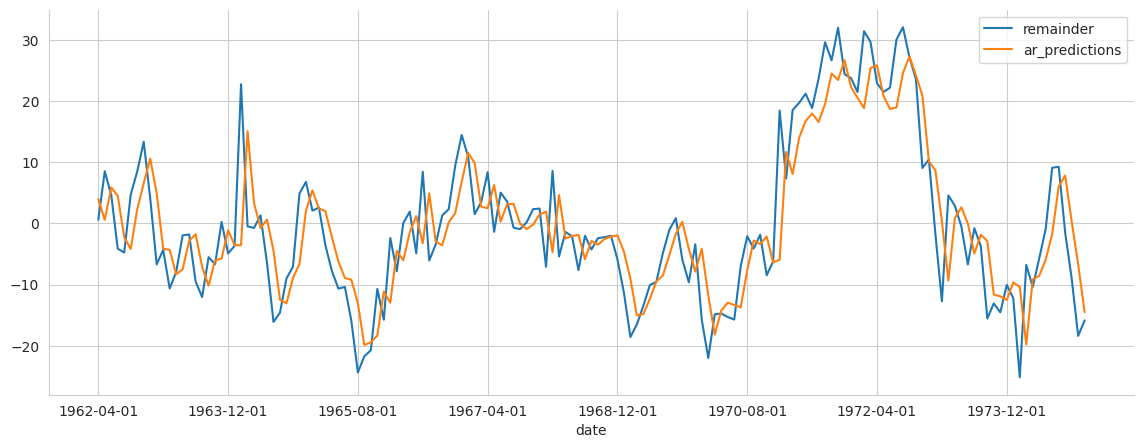

In [13]:
# Plot original remainder and prediction

df[['remainder','ar_predictions']].plot(figsize=(14,5),legend=True)
sns.despine()

**Q: How many lags should we use for the autoregressive model?**

<hr style="border:2px solid black">

## 5. (Partial) Autocorrelation

**Autocorrelation**

Correlation between observation at the current time spot and the observations at a previous time spot

$$
corr(y_t,y_{t-h}) = \frac{cov(y_t,y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

Because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation

**Partial Autocorrelation**

Correlation between observations at two time spots, conditional on the observations at the intermediate time spots:

$$
\delta_h = corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

They are basically the coefficients in a linear regression if $h$ lags are included

**(Partial) Autocorrelation Function (ACF & PACF)**

In [14]:
# function provided by statsmodels

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

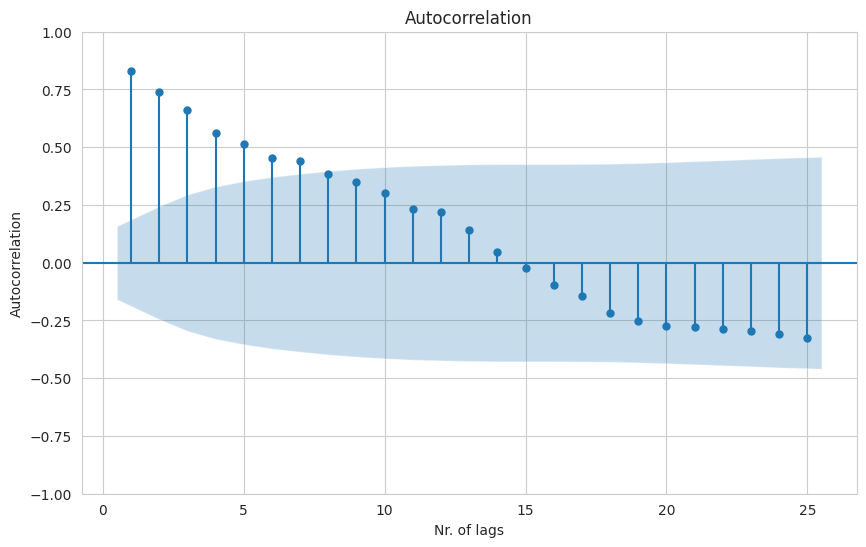

In [15]:
# plot autocorrelation function

plot_acf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

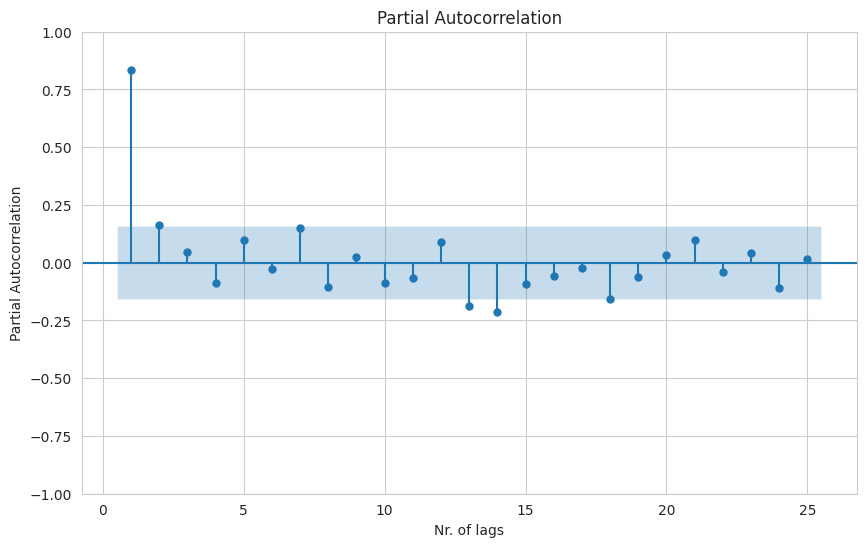

In [16]:
# plot partial autocorrelation function

plot_pacf(df['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation');

***We choose all lags until the first partial autocorrelation value ends up within the confidence interval***

<hr style="border:2px solid black">

## 6. Assumtions of AR Model

**Linearity**
- linear relationship between observation and time-lagged features

**Weak Stationarity**
- The statistical properties of the series do not depend on the time at which the series is observed. In other words, a time series is stationary if the expectation, variance and autocorrelations do not change over time:

$$
E(y_t)=E(y)=\mu,
\qquad V(y_t)=V(y)=\sigma²,
\qquad corr(y_t,y_{t-h})=c_h
$$

- In the long run, a stationary time series is not predictible

**Weak Dependence**
- Autocorrelation becomes smaller and smaller as lag becomes larger

<hr style="border:2px solid black">

## 7. IID Noise

In [17]:
# residual noise

df['residuals_ar'] = df['remainder'] - df['ar_predictions']

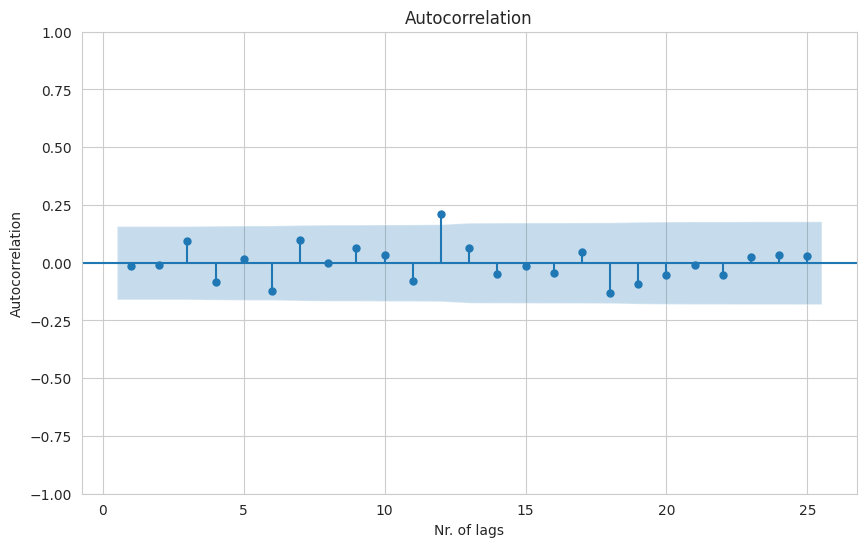

In [18]:
# plot autocorrelation function

plot_acf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation');

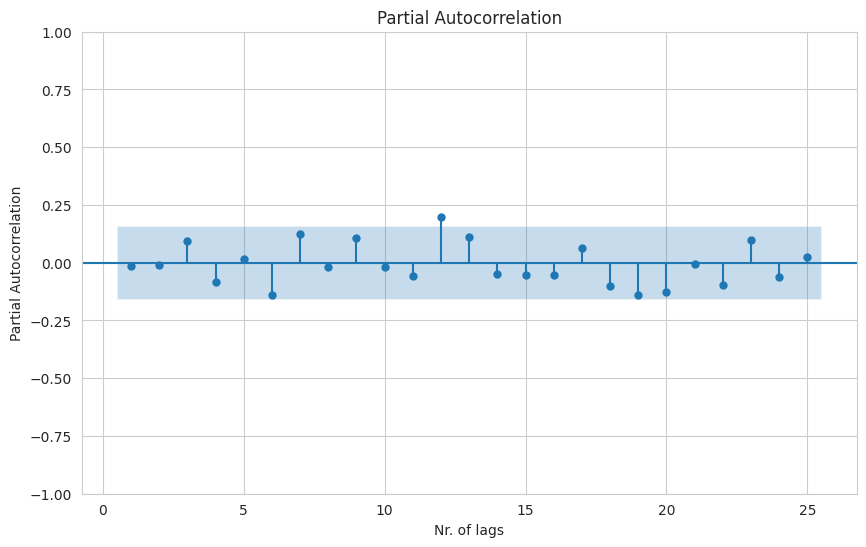

In [19]:
# plot partial autocorrelation function

plot_pacf(df['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None

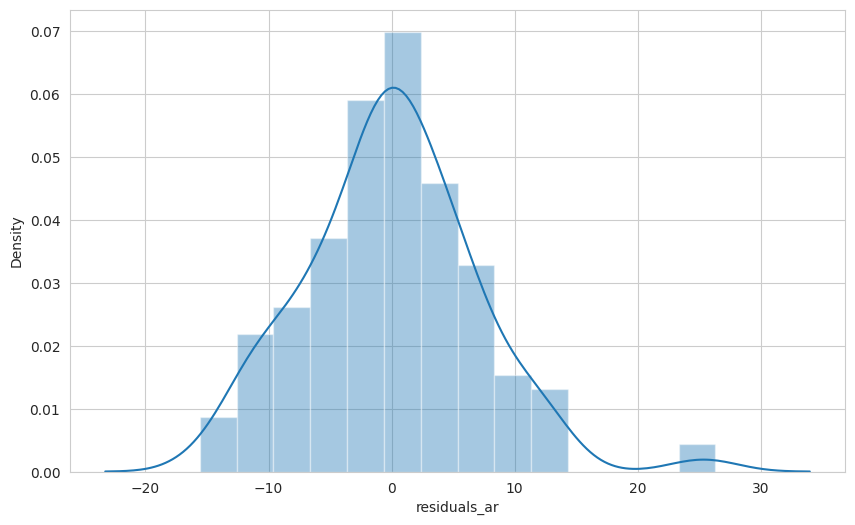

In [20]:
# distribution of residuals

sns.distplot(df['residuals_ar']);